In [1]:
import pandas as pd
import numpy as np
import sys,os,glob
import cv2
import shutil
import gc
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import time

from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model

## 训练数据和测试数据预处理

In [2]:
cur_dir=os.path.abspath(os.curdir)
model_persistance_path="../model_persistance"
base_path=r"../data/image/huxingtu_detection"
train_path=os.path.join(base_path,"train_data")
test_path=os.path.join(base_path,"test_data")
fixed_size=(229,229)

In [3]:
list_train_photo= glob.glob(os.path.join(train_path, '*/*.jpg'))
list_test_photo=glob.glob(os.path.join(test_path, '*/*.jpg'))
print("Train photos count :{}".format(len(list_train_photo)))
print("Test photos count :{}".format(len(list_test_photo)))


Train photos count :10865
Test photos count :120


In [4]:
def photo_display(paths):
    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(random.sample(paths, 6)):
        img = load_img(img_path)
        img = img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 3, i+1)
        plt.imshow(img.squeeze())

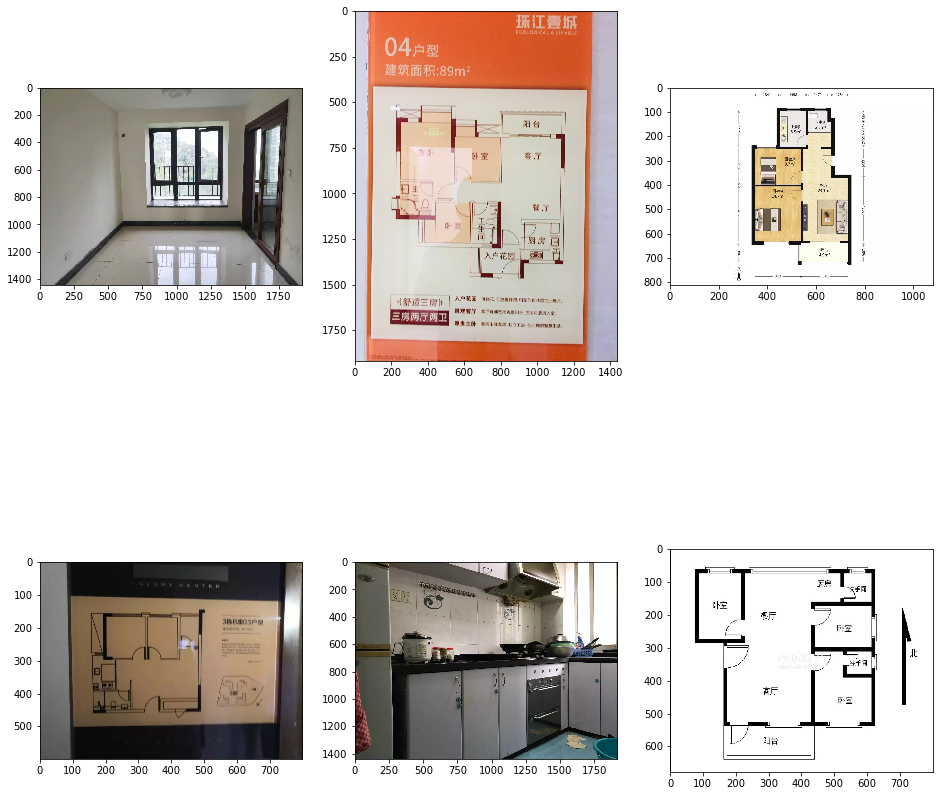

In [5]:
photo_display(list_train_photo)

## 对数据进行分组

### 训练数据

In [6]:
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  validation_split=0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=fixed_size, 
    batch_size=16,
    class_mode='categorical', 
    subset='training', 
    seed=0)

Found 8692 images belonging to 2 classes.


### 验证数据

In [8]:
validation_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  validation_split=0.2)

In [9]:
validation_generator = validation_datagen.flow_from_directory(
    train_path, 
    target_size=fixed_size, 
    batch_size=16,
    class_mode='categorical', 
    subset='validation', 
    seed=0)

Found 2173 images belonging to 2 classes.


### label map 和 data shape

In [10]:
label_index_map=labels = (train_generator.class_indices)
index_label_map = dict((v,k) for k,v in labels.items())
print(index_label_map)
print(label_index_map)

{0: 'huxingtu', 1: 'others'}
{'huxingtu': 0, 'others': 1}


In [11]:
x,y=train_generator.__getitem__(1)

In [12]:
x.shape

(16, 229, 229, 3)

In [13]:
y.shape

(16, 2)

## 模型配置和训练

### 预训练模型的载入 网络结构设计

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


### 锁住base model 的参数

In [15]:
for layer in base_model.layers:
    layer.trainable = False

### 模型编译和训练

In [16]:
filepath="ModelCheckpoint/model_{epoch:02d}-{val_acc:.4f}.h5"
early_stopping=EarlyStopping(patience=5,min_delta=1e-3)
model_checkpoint=ModelCheckpoint(filepath, monitor='val_acc',verbose=1,save_best_only=True)

In [17]:
len(train_generator)

544

In [18]:
len(validation_generator)

136

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        epochs=40,
        validation_data=validation_generator,
        callbacks=[early_stopping]
        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 42/544 [=>............................] - ETA: 13:48 - loss: 7.3587 - acc: 0.5298

### 锁住249层之前的参数，开放249层之后的所有参数（包括添加的全连接层和softmax层）

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

### 二次编译训练

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fit_history=model.fit_generator(
            train_generator,
            epochs=70,
            validation_data=validation_generator,
            callbacks=[early_stopping,model_checkpoint])

## 模型评估

### 学习曲线

In [ ]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'b-')
  plt.plot(epochs, val_acc, 'r-')
  plt.title('Training and validation accuracy')
  plt.figure()
  plt.plot(epochs, loss, 'b-')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

In [ ]:
plot_training(fit_history)

### 模型评估

In [ ]:
model.evaluate_generator(train_generator)

In [ ]:
model.evaluate_generator(validation_generator)

In [ ]:
# 测试集
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(
    test_path,
    target_size=fixed_size, 
    batch_size=16,
    class_mode='categorical')

In [ ]:
test_evaluate_result=model.evaluate_generator(generator)
print(test_evaluate_result)

### 模型保存

In [ ]:
filename="model_{test_evaluate_loss}_{test_evaluate_acc}.h5".format(test_evaluate_loss=test_evaluate_result[0],
                                                                    test_evaluate_acc=test_evaluate_result[1])
                                                               
filepath=os.path.join(model_persistance_path,filename)
model.save(filepath)

### 预测

In [ ]:
def predict(img):
    if img.size != fixed_size:
        img = img.resize(fixed_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [ ]:
def inference(photo_list):
    wrong_predict=[]
    for p in photo_list:
        true_label=p.split("\\")[-2]
        img=Image.open(p)
        res=predict(img)
        pre_label=index_label_map[res.argmax()]
        if true_label==pre_label:
            print("RIGHT fact:{}---->predict:{}".format(true_label,pre_label))
        else:
            print("WRONG fact:{}---->predict:{}".format(true_label,pre_label))
            wrong_predict.append(p)

In [ ]:
inference(list_test_photo)